In [1]:
import numpy as np
import tqdm as tqdm
import sklearn.datasets as skd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde

# tf and friends
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
import sonnet as snt
tf.enable_v2_behavior()

tfb = tfp.bijectors
tfd = tfp.distributions

gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
print(gpus)

2021-08-06 20:18:16.235710: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2021-08-06 20:18:17.332285: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-08-06 20:18:17.378903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-06 20:18:17.379292: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1660 computeCapability: 7.5
coreClock: 1.83GHz coreCount: 22 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 178.86GiB/s
2021-08-06 20:18:17.379311: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-08-06 20:18:17.381393: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-06 20:18:17.381424: I tensorflow/stream_executor/platform/de

In [2]:
import matplotlib.pyplot as plt
from HDF5DatasetGenerator import HDF5DatasetGenerator

In [3]:
generator = HDF5DatasetGenerator('../data/a1TrainGenerator.hdf5',int(2e5))
data = next(generator.generator())

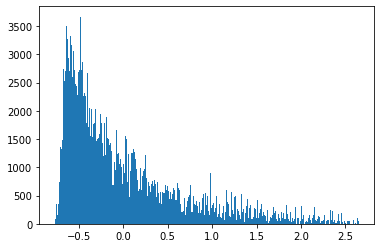

In [4]:
plt.hist(data[:,0],bins=300)
plt.show()

In [5]:
x = data[:,(0,1)]

In [6]:
base_loc = np.array([0.0, 0.0]).astype(np.float32)
base_sigma = np.array([0.8, 0.8]).astype(np.float32)
base_distribution = tfd.MultivariateNormalDiag(base_loc, base_sigma)

2021-08-06 20:18:17.751401: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-06 20:18:17.752364: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-06 20:18:17.753042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:04:00.0 name: GeForce GTX 1660 computeCapability: 7.5
coreClock: 1.83GHz coreCount: 22 deviceMemorySize: 5.80GiB deviceMemoryBandwidth: 178.86GiB/s
2021-08-06 20:18:17.753114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but the

In [7]:
base_distribution.prob([8,1])

<tf.Tensor: shape=(), dtype=float32, numpy=2.195955e-23>

In [8]:
class MLP_ODE(snt.Module):
  """Multi-layer NN ode_fn."""
  def __init__(self, num_hidden, num_layers, num_output, name='mlp_ode'):
    super(MLP_ODE, self).__init__(name=name)
    self._num_hidden = num_hidden
    self._num_output = num_output
    self._num_layers = num_layers
    self._modules = []
    for _ in range(self._num_layers - 1):
      self._modules.append(snt.Linear(self._num_hidden))
      self._modules.append(tf.math.tanh)
    self._modules.append(snt.Linear(self._num_output))
    self._model = snt.Sequential(self._modules)

  def __call__(self, t, inputs):
    inputs = tf.concat([tf.broadcast_to(t, inputs.shape), inputs], -1)
    return self._model(inputs)

In [9]:
LR = 1e-2 
NUM_EPOCHS = 20
STACKED_FFJORDS = 4
NUM_HIDDEN = 9
NUM_LAYERS = 5
NUM_OUTPUT = 2

In [10]:
solver = tfp.math.ode.DormandPrince(atol=1e-5)
ode_solve_fn = solver.solve
trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact

bijectors = []
for _ in range(STACKED_FFJORDS):
  mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT)
  next_ffjord = tfb.FFJORD(
      state_time_derivative_fn=mlp_model,ode_solve_fn=ode_solve_fn,
      trace_augmentation_fn=trace_augmentation_fn)
  bijectors.append(next_ffjord)

stacked_ffjord = tfb.Chain(bijectors[::-1])

In [11]:
transformed_distribution = tfd.TransformedDistribution(
    distribution=base_distribution, bijector=stacked_ffjord)

In [12]:
@tf.function
def train_step(optimizer, target_sample):
  with tf.GradientTape() as tape:
    loss = -tf.reduce_mean(transformed_distribution.log_prob(target_sample))
  variables = tape.watched_variables()
  gradients = tape.gradient(loss, variables)
  optimizer.apply(gradients, variables)
  return loss

In [13]:
@tf.function
def get_samples():
  base_distribution_samples = base_distribution.sample(SAMPLE_SIZE)
  transformed_samples = transformed_distribution.sample(SAMPLE_SIZE)
  return base_distribution_samples, transformed_samples


@tf.function
def get_transformed_grid():
  transformed_grid = stacked_ffjord.forward(grid)
  return transformed_grid

In [14]:
SAMPLE_SIZE = int(len(x)/10)

In [15]:
learning_rate = tf.Variable(LR, trainable=False)
optimizer = snt.optimizers.Adam(learning_rate)

for epoch in tqdm.trange(NUM_EPOCHS // 2):
    base_samples, transformed_samples = get_samples()
    #transformed_grid = get_transformed_grid()
    #evaluation_samples.append(
    #  (base_samples, transformed_samples, transformed_grid))
    for i in range(1024,len(x),1024):
        batch = x[i-1024:i]
        _ = train_step(optimizer, batch)

  0%|                                                    | 0/10 [00:00<?, ?it/s]2021-08-06 20:18:20.925997: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-08-06 20:18:20.944318: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3593575000 Hz
2021-08-06 20:18:26.640967: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-08-06 20:18:26.990192: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


100%|███████████████████████████████████████████| 10/10 [15:52<00:00, 95.25s/it]


In [16]:
a = transformed_distribution.sample(x.shape[0]).numpy()

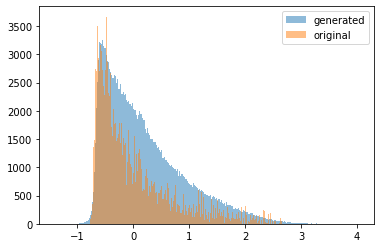

In [17]:
plt.hist(a[:,0],bins=300,alpha=0.5)
plt.hist(x[:,0],bins=300,alpha=0.5)
plt.legend(['generated','original'])
plt.show()

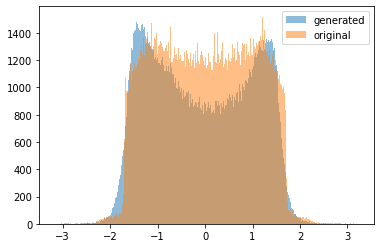

In [18]:
plt.hist(a[:,1],bins=300,alpha=0.5)
plt.hist(x[:,1],bins=300,alpha=0.5)
plt.legend(['generated','original'])
plt.show()

In [19]:
keys = ['E', 'X', 'Y', 'dX', 'dY', 'dZ']

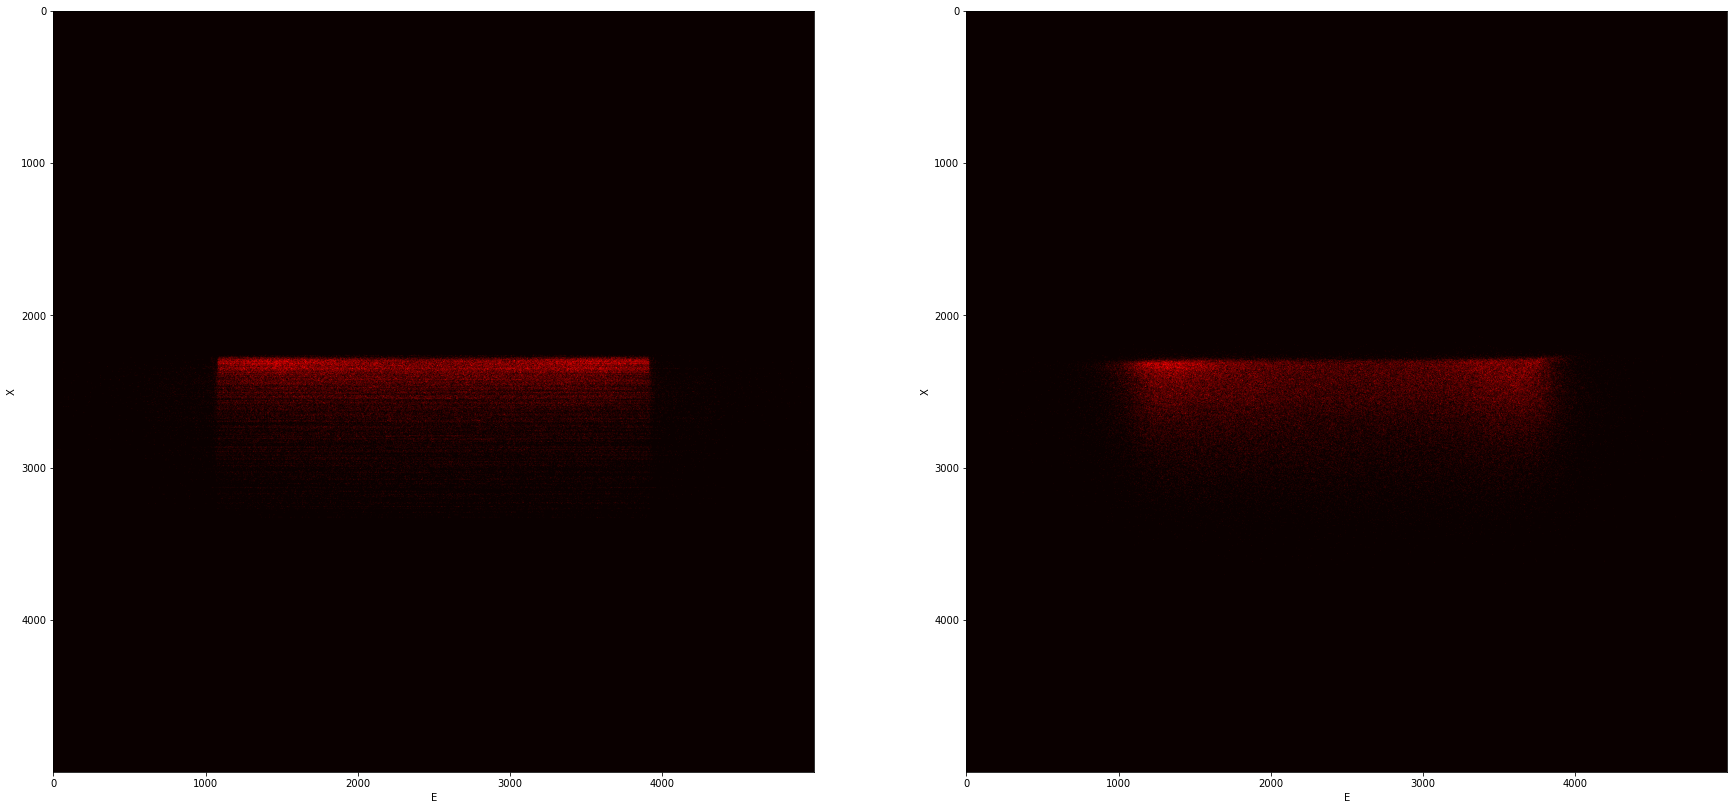

In [20]:
fig,axs = plt.subplots(1,2)
fig.set_size_inches((30,30))

temp = np.histogramdd(x,bins=[5000,5000],range=[[-8,8],[-3,3]])
temp_im = np.tanh(temp[0])
axs.flatten()[0].imshow(temp_im,cmap='hot')
axs.flatten()[0].set_xlabel(keys[0])
axs.flatten()[0].set_ylabel(keys[1])

temp = np.histogramdd(a,bins=[5000,5000],range=[[-8,8],[-3,3]])
temp_im = np.tanh(temp[0])
axs.flatten()[1].imshow(temp_im,cmap='hot')
axs.flatten()[1].set_xlabel(keys[0])
axs.flatten()[1].set_ylabel(keys[1])
plt.show()